In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json

from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize


# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [6]:
!wget -q -O 'newyork_boroughs_neighborhoods_data.json' https://cocl.us/new_york_dataset 
print('Dataset extracted and downloaded to newyork_boroughs_neighborhoods_data')

with open('newyork_boroughs_neighborhoods_data.json') as json_data:
    ny_data = json.load(json_data)
print('Opened the dataset extracted and loaded as JSON format')    

Dataset extracted and downloaded to newyork_boroughs_neighborhoods_data
Opened the dataset extracted and loaded as JSON format


In [7]:
data_of_NY = ny_data['features']
df_ny = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for data in data_of_NY:    
    df_ny = df_ny.append({'Borough': data['properties']['borough'],
                                          'Neighborhood': data['properties']['name'],
                                          'Latitude':  data['geometry']['coordinates'][1],
                                          'Longitude': data['geometry']['coordinates'][0]}, ignore_index=True)
print('Transform the dataset as JSON into dataframe extracting four features')

Transform the dataset as JSON into dataframe extracting four features


In [8]:
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
df_ny.shape

(306, 4)

<h4>Grouping by borough and counting neighborhoods in every borough

In [10]:
# We group by Borough and count the Neighborhoods in every one of them.
neighborhoods_in_boroughs = df_ny.groupby(['Borough'])['Neighborhood'].count()
neighborhoods_in_boroughs

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

<h4>As we can see, Brooklyn is the borough with more neighborhoods. So, this is an indicator that whould be important considers to open a business.
But also, it is important to search other indicators like population, GDP, and dansity of population.

In [11]:
g = df_ny.groupby('Borough')
df_brooklyn = g.get_group('Brooklyn')
df_brooklyn.reset_index(inplace=True, drop=True)
print(df_brooklyn.shape)
df_brooklyn.head()

(70, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [12]:
# Gets coordinates of NY City to create the map
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [13]:
import folium
# creates map of New York using latitude and longitude values of neighborhoods
newyork_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_brooklyn['Latitude'], df_brooklyn['Longitude'], df_brooklyn['Borough'], df_brooklyn['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(newyork_map)  
    
newyork_map

In [14]:
CLIENT_ID = 'CYOZ4YP53MYMNGMXDUTPEQNCA1XXBDOC1DXYMF13HHO3DQDQ' # your Foursquare ID
CLIENT_SECRET = 'SN3DFCYX31PF4JCF0G3OTEZM5I3CTX2GURDSPM0P3Z4XGU0Y' # your Foursquare Secret
ACCESS_TOKEN = 'TOHLJH4GJCHQUCS4KXJ3N5GXNBVOJ0UF0GVUVSN5ZVCQKNW3' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [15]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [46]:
#https://developer.foursquare.com/docs/resources/categories # lets to find the code for bakeries 
#Bakery 4bf58dd8d48988d16a941735
#Creates a dataframe with businesses whose category is 4bf58dd8d48988d16a941735

bakery_brooklyn_venues = getNearbyVenues(names=df_brooklyn['Neighborhood'], \
    latitudes=df_brooklyn['Latitude'], longitudes=df_brooklyn['Longitude'], \
    radius=1000, categoryIds='4bf58dd8d48988d16a941735')
print(bakery_brooklyn_venues.shape)
bakery_brooklyn_venues.head()

(1181, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Cinnabon,40.623156,-74.031459,Sandwich Place
1,Bay Ridge,40.625801,-74.030621,Bay Ridge Diner,40.625304,-74.024340,American Restaurant
2,Bay Ridge,40.625801,-74.030621,Little Cupcake Bakeshop,40.620021,-74.032567,Cupcake Shop
3,Bay Ridge,40.625801,-74.030621,Paneantico,40.619368,-74.032814,Bakery
4,Bay Ridge,40.625801,-74.030621,Leske's Bakery,40.628456,-74.023100,Bakery


In [17]:
# Count only bakeries
bakery_brooklyn_venues[bakery_brooklyn_venues['Venue Category'] == 'Bakery'].shape

(945, 7)

In [18]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(bakery_brooklyn_venues['Venue Latitude'], bakery_brooklyn_venues['Venue Longitude'], bakery_brooklyn_venues['Neighborhood'], bakery_brooklyn_venues['Venue'], bakery_brooklyn_venues['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [19]:
#Map with businesses in Brooklyn
brooklyn_bakery_map = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(brooklyn_bakery_map, 'green', brooklyn_bakery_map)

brooklyn_bakery_map

In [20]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [22]:
# Number of businesses filtered by category and ordered by venue.
brooklyn_grouped = bakery_brooklyn_venues.groupby('Neighborhood').count()
print('There are {} venues with businesses'.format(len(bakery_brooklyn_venues['Venue Category'].unique())))
brooklyn_grouped  = brooklyn_grouped[['Venue']]
brooklyn_grouped

There are 34 venues with businesses


,Venue
Neighborhood,
Bath Beach,23
Bay Ridge,23
Bedford Stuyvesant,16
Bensonhurst,26
Boerum Hill,28
Borough Park,24
Brighton Beach,12
Broadway Junction,8
Brooklyn Heights,24


In [23]:
# Only bakeries
brooklyn_just_bakeries = pd.get_dummies(bakery_brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")
brooklyn_just_bakeries['Neighborhood'] = bakery_brooklyn_venues['Neighborhood'] 
brooklyn_just_bakeries = brooklyn_just_bakeries[['Neighborhood', 'Bakery']]
brooklyn_just_bakeries[brooklyn_just_bakeries['Neighborhood'] == 'Coney Island']
# Shows the number of bakeries in the vanue selected indicated by the number 1

,Neighborhood,Bakery
556,Coney Island,0
557,Coney Island,0
558,Coney Island,0
559,Coney Island,0
560,Coney Island,0
561,Coney Island,1
562,Coney Island,1


In [24]:
#brooklyn_grouped_mean = brooklyn_grouped.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped_mean = brooklyn_just_bakeries.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped_mean.sort_values(by = 'Bakery').head()

,Neighborhood,Bakery
59,Sea Gate,0.000000
16,Coney Island,0.285714
28,Flatlands,0.400000
62,Starrett City,0.500000
51,Paerdegat Basin,0.500000


In [26]:
bakery_brooklyn_venues[bakery_brooklyn_venues['Neighborhood'] == 'Coney Island']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
556,Coney Island,40.574293,-73.988683,"New York Bread, Inc.",40.578806,-73.990076,Gourmet Shop
557,Coney Island,40.574293,-73.988683,Auntie Anne's,40.572896,-73.987915,Food Stand
558,Coney Island,40.574293,-73.988683,Baskin-Robbins,40.575809,-73.981043,Ice Cream Shop
559,Coney Island,40.574293,-73.988683,Baskin-Robbins,40.575642,-73.997213,Ice Cream Shop
560,Coney Island,40.574293,-73.988683,Auntie Anne’s,40.575721,-73.979890,Snack Place
561,Coney Island,40.574293,-73.988683,Piece Of Cake,40.576525,-73.985548,Bakery
562,Coney Island,40.574293,-73.988683,Victoria Bakery,40.580458,-73.983798,Bakery


<h3>For additional analysis

In [27]:
!pip install lxml
!pip install beautifulsoup4
from bs4 import BeautifulSoup
print('Required to extract demography from wikipedia page')

Required to extract demography from wikipedia page


In [48]:
from pandas.io.html import read_html
wikipedia_page = 'https://en.wikipedia.org/wiki/Demographics_of_New_York_City'
tables_from_page = read_html(wikipedia_page, attrs = {'class':'wikitable'})
df_ny_demography = tables_from_page[0]
df_ny_demography

New York City's five boroughs.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:"[ "}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:" ]"}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}.mw-parser-output .infobox .navbar{font-size:100%}.mw-parser-output .navbox .navbar{display:block;font-size:100%}.mw-parser-output .navbox-title .navbar{float:left;text-align:left;margin-right:0.5em}vte  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Jurisdiction   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Borough   
0                                          The Bronx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1                                           Brooklyn                                                                                                                                  

In [49]:
# Data cleaning: Eliminates the extra information in columns and eliminates columns not useful.
df_ny_demography.columns = ['Borough','c','Population','GDP','c','c','Density','c','c'] # Renames columns
df_ny_demography.drop(columns=['c'],inplace=True)  # Drops columns we are not use them
df_ny_demography.drop(df_ny_demography.index[5:8],inplace=True)  #Drosp rows we are not use them
df_ny_demography

,Borough,Population,GDP,Density
0,The Bronx,1418207,42.695,33867
1,Brooklyn,2559903,91.559,36147
2,Manhattan,1628706,600.244,71341
3,Queens,2253858,93.310,20767
4,Staten Island,476143,14.514,8157


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


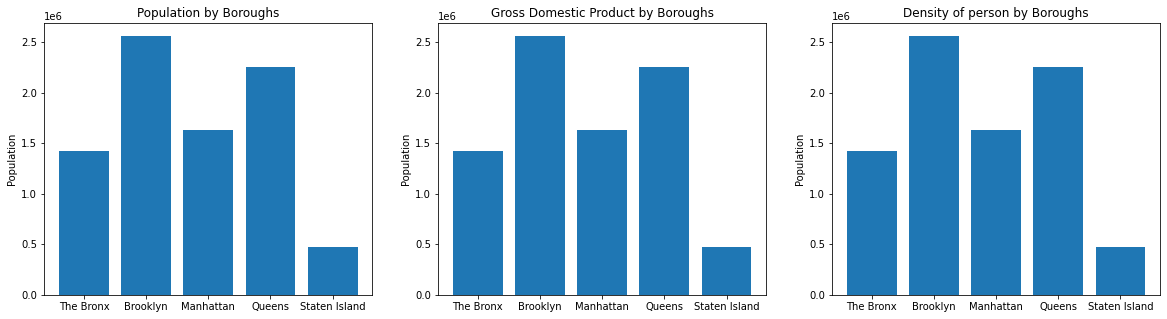

In [30]:
x = list(df_ny_demography['Borough'])
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ypop = np.array(list(df_ny_demography['Population'])).astype(np.int)
ygdp = np.array(list(df_ny_demography['GDP']))
yden = np.array(list(df_ny_demography['Density'])).astype(np.int)

ax1.bar(x,ypop)
ax1.set_xticklabels(x, fontsize='10')
ax1.set_title('Population by Boroughs')
ax1.set_ylabel('Population')

ax2.bar(x,ypop)
ax2.set_xticklabels(x, fontsize='10')
ax2.set_title('Gross Domestic Product by Boroughs')
ax2.set_ylabel('Population')

ax3.bar(x,ypop)
ax3.set_xticklabels(x, fontsize='10')
ax3.set_title('Density of person by Boroughs')
ax3.set_ylabel('Population')

plt.show()

In [31]:
import pandas as pd 
brooklyn_neigbor = pd.read_excel('bn.xlsx')
brooklyn_neigbor.head(20)

,Neighborhood,Population,Average Household Income
0,Bath Beach,30221.0,79318.60
1,Bay Ridge,85791.0,90550.57
2,Bedford Stuyvesant,156464.0,69272.22
3,Bensonhurst,58850.0,74157.16
4,Boerum Hill,11989.0,169377.94
5,Borough Park,133878.0,70148.35
6,Brighton Beach,78775.0,81900.00
7,Broadway Junction,NaN,NaN
8,Brooklyn Heights,63378.0,186984.00
9,Brownsville,75605.0,44364.00


In [32]:
brooklyn_neigbor = brooklyn_neigbor.dropna()
brooklyn_neigbor.shape

(46, 3)

In [33]:
brooklyn_neigbor.mean()

Population                   63754.021739
Average Household Income    103758.622391
dtype: float64

In [ ]:
brooklyn_neigbor.sort_values(by = 'Population', ascending = False )

In [34]:
import seaborn as sns
import sklearn.cluster as cluster
bn_values = brooklyn_neigbor[['Population','Average Household Income']]
bn_values.head()

,Population,Average Household Income
0,30221.0,79318.60
1,85791.0,90550.57
2,156464.0,69272.22
3,58850.0,74157.16
4,11989.0,169377.94


In [35]:
K=range (1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(bn_values)
    wss_iter = kmeans.inertia_
    wss.append (wss_iter)

In [36]:
mycenters = pd.DataFrame({'Cluster' : K, 'WSS': wss})
mycenters

,Cluster,WSS
0,1,1.576716e+11
1,2,7.406193e+10
2,3,3.806268e+10
3,4,2.532414e+10
4,5,1.862182e+10
5,6,1.495057e+10
6,7,1.133054e+10
7,8,9.317742e+09
8,9,8.175181e+09
9,10,6.851369e+09


<AxesSubplot:xlabel='Cluster', ylabel='WSS'>

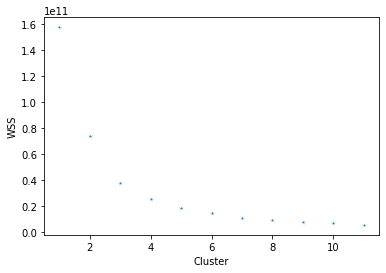

In [37]:
sns.scatterplot(x = 'Cluster', y = 'WSS', data = mycenters, marker = '*')

In [42]:
kmeans = cluster.KMeans(n_clusters=4 ,init="k-means++")
kmeans = kmeans.fit(bn_values)

In [43]:
brooklyn_neigbor['Clusters'] = kmeans.labels_

<AxesSubplot:xlabel='Population', ylabel='Average Household Income'>

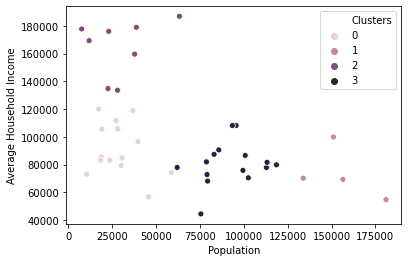

In [44]:
sns.scatterplot(x="Population", y="Average Household Income",hue = "Clusters", data=brooklyn_neigbor)

In [45]:
venues_option = brooklyn_neigbor[brooklyn_neigbor['Population'].between(75000, 125000) \
                & brooklyn_neigbor['Average Household Income'].between(70000, 110000) ]
venues_option

,Neighborhood,Population,Average Household Income,Clusters
1,Bay Ridge,85791.0,90550.57,3
6,Brighton Beach,78775.0,81900.00,3
10,Bushwick,102607.0,70401.52,3
11,Canarsie,100844.0,86568.00,3
17,Crown Heights,118623.0,79791.13,3
27,Flatbush,99558.0,75780.00,3
32,Georgetown,95666.0,108156.00,3
33,Gerritsen Beach,83119.0,87360.00,3
35,Gravesend,112900.0,77822.67,3
41,Manhattan Beach,78775.0,81900.00,3
